In [1]:
# Относительные ссылки, включая импорты, относительно корневой папки проекта
import os
os.chdir(os.path.dirname(os.getcwd()))

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings


In [2]:
fact = pd.read_csv("./DataWagon/data/fact_train_test.csv", sep=";", decimal=",", encoding="windows-1251")
fact["period"] = fact["period"].astype("datetime64[ns]")
start_date_prep =  datetime(2017, 1, 1).strftime("%Y-%d-%m")
fact = fact.loc[fact['period'] >= start_date_prep]


In [3]:
fact

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count
2468,2017-01-01,0,0,0,-1,23,11020,37638,672,62.0,5
2469,2017-01-01,0,0,0,-1,4225,11020,37638,672,13.0,2
2470,2017-01-01,0,0,0,-1,4228,11020,37638,672,6.0,0
2471,2017-01-01,0,0,0,-1,4293,11020,37638,672,14.0,0
2472,2017-01-01,0,0,0,-1,3320,11020,37638,672,52.0,0
...,...,...,...,...,...,...,...,...,...,...,...
3559227,2023-03-01,1,5,2,1346,1482,31438,31482,0,69.0,1
3559228,2023-03-01,1,5,2,1346,1492,31438,36091,27275,70.0,1
3559229,2023-03-01,1,5,2,1346,1492,31438,35450,27275,70.0,1
3559230,2023-03-01,1,5,2,1346,1492,31438,31482,0,207.0,3


In [21]:
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

In [38]:
df = fact.copy()
# df_agg = df.groupby([
#         df.period.dt.date, 
#         "rps",
#         "client_sap_id",
#         "sender_station_id",
#         "recipient_station_id",
#         "real_wagon_count",
# ]).sum().reset_index()
# result_agg.loc[result_agg['period']<= end_validation, 'real_wagon_count'], 
end_train =  fact["period"].max().date().strftime("%Y-%d-%m") # datetime(2023, 3, 1)
exclude_col = ['real_wagon_count', 'period']

data_train = df.loc[df['period'] <= end_train]
data_test = df.loc[df['period'] > end_train]

X_train = data_train.drop(exclude_col, axis=1)
X_test = data_test.drop(exclude_col, axis=1)
y_train = data_train['real_wagon_count']
y_test = data_test['real_wagon_count']

model = Ridge(random_state=42) #LGBMRegressor(random_state=42)
model.fit(X_train, y_train)


Ridge(random_state=42)

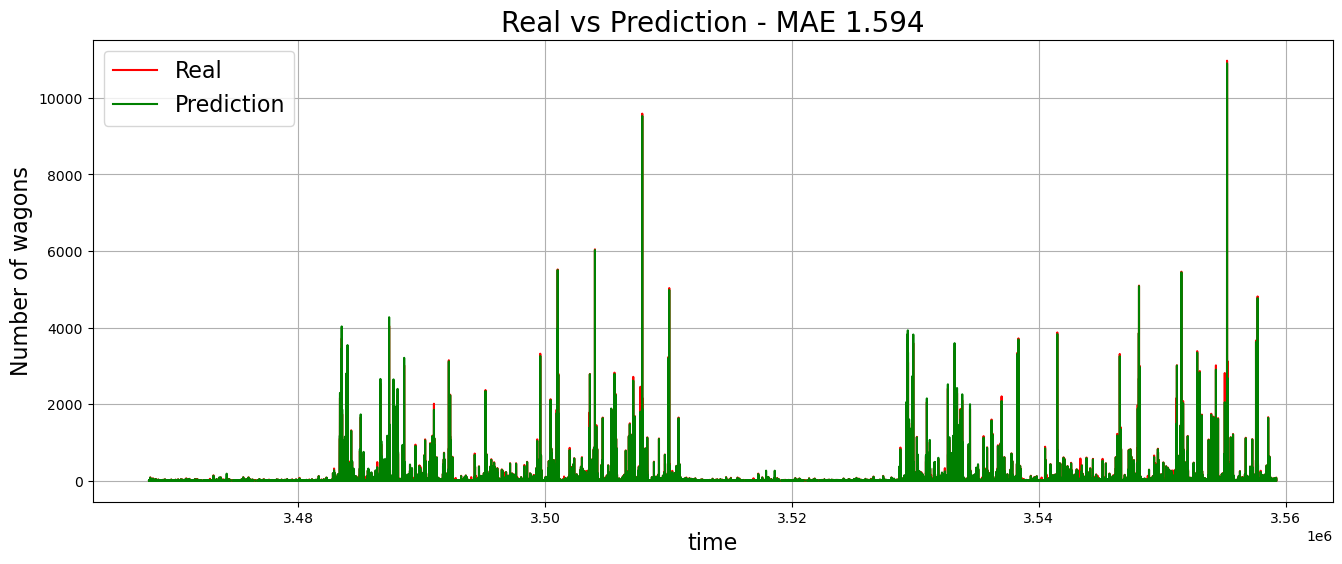

AttributeError: 'Ridge' object has no attribute 'feature_name_'

In [40]:
predictions = model.predict(X_test)
mae = np.round(mean_absolute_error(y_test, predictions), 3)
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(predictions, index=y_test.index), color='green')
plt.xlabel('time', fontsize=16)
plt.ylabel('Number of wagons', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False) 

#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()


In [29]:
result = []
last_known_fact_month = fact["period"].max()#-pd.DateOffset(months=5)
test_periods = pd.date_range(start=fact["period"].max()+pd.DateOffset(months=1), periods=5, freq='MS')#, inclusive='right'

# new_months = fact[fact["period"]>=last_known_fact_month-pd.DateOffset(months=6)].reset_index(drop=True)
for i, period in enumerate(test_periods):
    print(period)
    # last_known_fact_month += pd.DateOffset(months=1)
    # print(last_known_fact_month)
    month_forecast = fact[fact["period"] == last_known_fact_month].reset_index(drop=True) #new_12_months.copy()
    # month_forecast = new_months.copy()
    month_forecast["period"] = period
    result.append(month_forecast)
result = pd.concat(result).reset_index(drop=True)

pred_row = result.drop(exclude_col, axis=1)
predictions = model.predict(pred_row)

result['real_wagon_count'] = predictions.round()
print(len(result))
result = result[result['real_wagon_count']> 0]
# result.loc[result['client_sap_id']==-1, ['client_sap_id']] = 0
print(len(result))

2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
239605
215370


In [26]:
result = result.reset_index(drop=True)
result.rename(columns={"real_wagon_count": "forecast_wagon_count", "real_weight": "forecast_weight"}, inplace=True)
result.to_csv("./DataWagon/data/forecast_result.csv", index=False, sep=";", decimal=",", encoding="windows-1251")